In [1]:
'''
Purge Fan Fault Classification Model using Residual Network
'''
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pathlib

import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transform
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchinfo import summary

import random
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# hyper parameters
DATA_BATCH_SIZE = 10
EPOCHS = 10
LEARNING_RATE = 0.01
GRAD_CLIP = 0.12
WEIGHT_DECAY = 0.0001


DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "MRO" / "PurgeFan" / "resnet_dataset"
print(DATASET_PATH) # show dataset path

# train dataset preparation
classes = ['normal', 'fault']   # two class
dataset = ImageFolder(DATASET_PATH, transform=transform.ToTensor()) # set image dataset directory and data transform
dataloader = DataLoader(dataset, batch_size=DATA_BATCH_SIZE) # data loader with batch size 10 (change if more GPU memory is available)

print(torch.__version__) # check CUDA toolkit version (must be matched CUDA Toolkit version and Pytorch version)
# [Note!] use pytorch 2.1.2, CUDA 11.8 on python virtual environment(using pip)
# [Note!] pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


# calc mean and std for image normalization
_sum_channels = 0
_squared_sum_channels =0
_total_batches = 0

for data, _ in tqdm(dataloader):
    _sum_channels += torch.mean(data, dim=[0,2,3]) # calc mean for each channels (dim=Batch, Channel, Height, Width)
    _squared_sum_channels += torch.mean(data**2, dim=[0,2,3])
    _total_batches += 1
mean = _sum_channels / _total_batches
std = (_squared_sum_channels / _squared_sum_channels - mean ** 2) ** 0.5

print(_sum_channels, _squared_sum_channels, _total_batches)
print(f"Mean : {mean}, Std:{std}")

# normalization(0~1) of dataset images
stats = (tuple(mean.tolist()), tuple(std.tolist()))
train_transform = transform.Compose([transform.ToTensor(), transform.Normalize(*stats, inplace=True)])
test_transform = transform.Compose([transform.ToTensor(), transform.Normalize(*stats)])

# performing transformation for all dataset
train_dataset = ImageFolder((DATASET_PATH/"train").as_posix(), train_transform)
test_dataset = ImageFolder((DATASET_PATH/"test").as_posix(), test_transform)

# create data loader (use page-lock to transfer the data into GPU memory)
train_dataloader = DataLoader(train_dataset, batch_size=DATA_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=DATA_BATCH_SIZE, num_workers=4, pin_memory=True)

# device selection function (GPU, CPU, MPS for MacOS)
def get_device_use():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
device = get_device_use()
print(f"Selected Device : {device}")

# transfer data into the selected device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device) -> None:
        self.__dataloader = dataloader
        self.__device = device
        
    def __iter__(self):
        for b in self.__dataloader:
            yield to_device(b, self.__device)
            
    def __len__(self):
        return len(self.__dataloader)
    
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

# Residual Network
class ModelBase(nn.Module):
    
    @staticmethod
    def __accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = self.__accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.__accuracy(out, labels)    # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, last_lr: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['lrs'][-1]))
        
class ResNet(ModelBase):
    # resnet layer block : conv2d -> batch normalization -> ReLu
    @staticmethod
    def __conv_block(in_channels, out_channels, pool=False):
        # output dim and input dim are the same (kernel size=3, padding=1)
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(num_features=out_channels), nn.ReLU(inplace=True)]
        if pool: 
            layers.append(nn.MaxPool2d(kernel_size=2))  # max pooling with 2 dim kernel
        return nn.Sequential(*layers) # combine into single block
    
    def __init__(self, channels, n_classes):
        super().__init__()
        
        self.conv1 = self.__conv_block(channels, 64)
        self.conv2 = self.__conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.__conv_block(128, 128), self.__conv_block(128, 128))
        
        self.conv3 = self.__conv_block(128, 256, pool=True)
        self.conv4 = self.__conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.__conv_block(512, 512), self.__conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, n_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# create resnet model
model = to_device(ResNet(channels=3, n_classes=2), device)
print(model)

# show model summary (check model structure)
# model = ResNet(channels=3, n_classes=2)
# summary(model, input_size=(DATA_BATCH_SIZE, 3, 224, 224))


# use Adam Optimization function
optimizer = torch.optim.Adam(model.parameters(),LEARNING_RATE,amsgrad=True, weight_decay=WEIGHT_DECAY)

# model training
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_end(outputs)

def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr, model, train_loader, val_loader,weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    _optimizer = opt_func
    sched = torch.optim.lr_scheduler.OneCycleLR(_optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in (range(epochs)):
        
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        lrs=[]
        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            _optimizer.step()
            _optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_learning_rate(_optimizer))
            sched.step()
            if batch_idx % 60 == 0:
                print(f'Train Epoch: {epoch+1} [{batch_idx}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss:.6f}, Accuracy: {accuracy:.4f}')

        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

print("Now start model training...")
history = fit(EPOCHS, LEARNING_RATE, model, train_dataloader, test_dataloader, grad_clip=GRAD_CLIP, weight_decay=WEIGHT_DECAY, opt_func=optimizer)

C:\Users\elecu\dev\flame-autonomous\dataset\MRO\PurgeFan\resnet_dataset
2.1.2+cu118


100%|██████████| 600/600 [00:38<00:00, 15.50it/s]


tensor([  7.0328,  43.6689, 504.4096]) tensor([  4.8845,  20.0613, 437.5969]) 600
Mean : tensor([0.0117, 0.0728, 0.8407]), Std:tensor([0.9999, 0.9973, 0.5415])
Selected Device : cuda
ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv

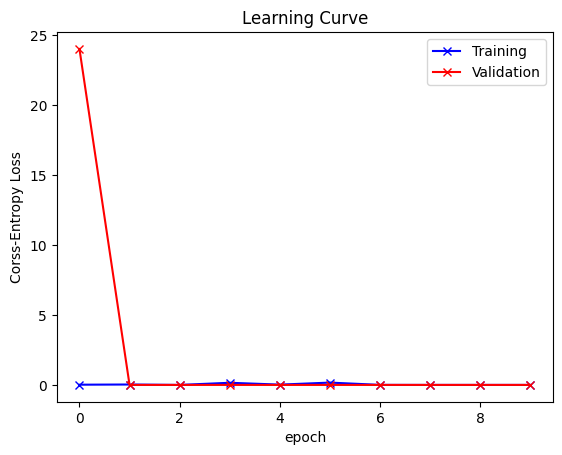

In [2]:
'''
Learning Curve Plot
'''
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('Corss-Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.title('Learning Curve')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

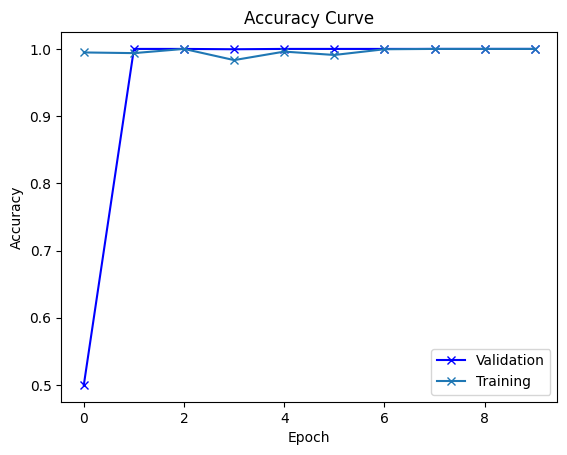

In [5]:
'''
Accuracy Plot
'''
train_accuracies= [x['train_accuracy'] for x in history]
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-bx')
plt.plot(train_accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Validation','Training'])
plt.title('Accuracy Curve')
plt.show

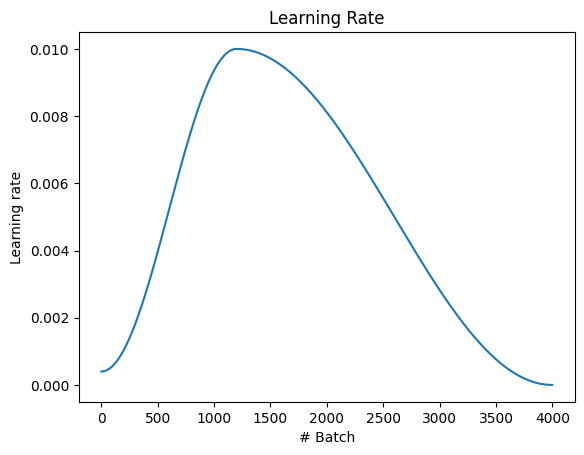

In [6]:
'''
Learning Rate Plot
'''

lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs)
plt.xlabel('# Batch')
plt.ylabel('Learning rate')
plt.title('Learning Rate')
plt.show()

In [3]:
'''
Save to model file
'''
torch.save(model.state_dict(), './resnet9_pfc.pth')

Label: fault , Predicted: fault


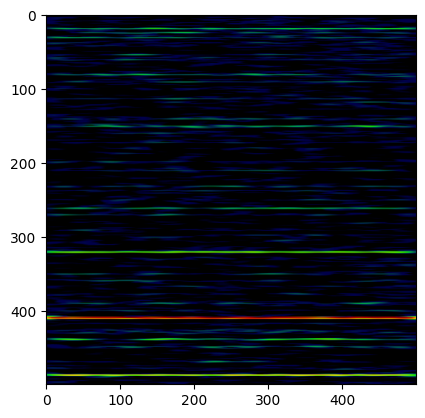

In [4]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

img, label = test_dataset[100]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [22]:
'''
use saved model
'''
def get_device_use():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
device = get_device_use()

pfc_model = to_device(ResNet(3, 2), device)
pfc_model.load_state_dict(torch.load('./resnet9.pth'))
evaluate(pfc_model, test_dataloader)

{'val_loss': 0.0, 'val_acc': 1.0}